# Our first RNN
Generic RNN for RNA sequence.

First goal.
Input sequence of K-mer frequencies, output binary classifier: protein-coding or non-coding.
Try to beat the DNN that we trained previously. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow import keras
tf.keras.backend.set_floatx('float64')

# Split into train/test stratified by sequence length.
def sizebin(df):
    return pd.cut(df["seqlen"],
                              bins=[0,1000,2000,4000,8000,16000,np.inf],
                              labels=[0,1,2,3,4,5])

In [4]:
nc3 = pd.read_csv ('ncRNA.3mer.features.csv')
pc3 = pd.read_csv ('pcRNA.3mer.features.csv')
nc3['class']=0
pc3['class']=1
rna3mer=pd.concat((nc3,pc3),axis=0)
bin_labels= sizebin(rna3mer)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
for train_index,test_index in splitter.split(rna3mer,bin_labels):
    train_set = rna3mer.iloc[train_index]
    test_set =  rna3mer.iloc[test_index]
y_train_all=  train_set[['class']].copy()
X_train_all=  train_set.div(train_set['seqlen'],axis=0)
X_train_all=  X_train_all.drop(columns=['class','seqnum','seqlen'])
y_test=   test_set[['class']].copy()
X_test=   test_set.div(test_set['seqlen'],axis=0)
X_test=   X_test.drop(columns=['class','seqnum','seqlen'])
X_train,y_train=X_train_all[:25000],y_train_all[:25000]
X_valid,y_valid=X_train_all[25000:],y_train_all[25000:]

In [6]:
act="sigmoid"
mlp2 = keras.models.Sequential([
    keras.layers.LayerNormalization(trainable=False),
    keras.layers.Dense(32, activation=act,dtype='float32'),
    keras.layers.Dense(32, activation=act,dtype='float32'),
    keras.layers.Dense(1,  activation=act,dtype='float32')
])
bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
mlp2.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
history = mlp2.fit(X_train,y_train,epochs=5,validation_data=(X_valid,y_valid))

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

782/782 [==============================] - 2s 3ms/step - loss: 0.6037 - accuracy: 0.6654 - val_loss: 0.5291 - val_accuracy: 0.7405
Epoch 2/5
782/782 [==============================] - 2s 2ms/step - loss: 0.5105 - accuracy: 0.7548 - val_loss: 0.5035 - val_accuracy: 0.7595
Epoch 3/5
782/782 [==============================] - 2s 3ms/step - loss: 0.4980 - accuracy: 0.7621 - val_loss: 0.4972 - val_accuracy: 0.7603
Epoch 4/5
782/782 [==============================] - 2s 3ms/step - loss: 0.4938 - acc

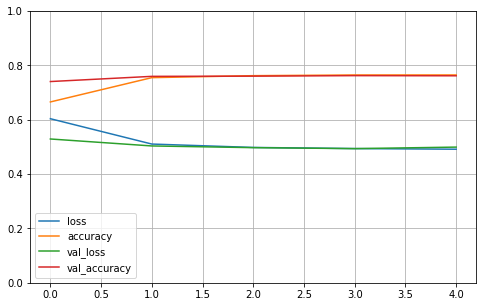

In [7]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()